C:\workspace\pycharm_workspace\OPSLINKED-AI-BITNET-SERVING\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data generation functions are defined.
LSTM Autoencoder model is defined.
Starting model training...
[INFO] Train data shape: (1991, 10, 10)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 10)         │         1,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,224 (28.22 KB)

 Trainable params: 7,224 (28.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8872 - val_loss: 0.9082
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8477 - val_loss: 0.8748
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.8272 - val_loss: 0.8615
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8173 - val_loss: 0.8563
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.8137 - val_loss: 0.8539
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.8120 - val_loss: 0.8527
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.8111 - val_loss: 0.8515
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8105 - val_loss: 0.8512
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.8100 - val_loss: 0.8505
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8097 - val_loss: 0.8503
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8093 - val_loss: 0.8500
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8

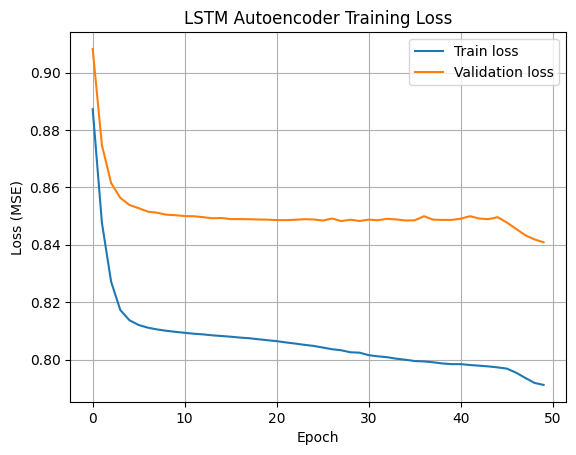


Uploading model and scaler to Hugging Face Hub...


HfHubHTTPError: (Request ID: Root=1-69038f2e-4473ca8f367bf960556a204b;99c5266d-639b-43f7-9571-45f0ef5e3882)

403 Forbidden: You don't have the rights to create a model under the namespace "YOUR_USERNAME".
Cannot access content at: https://huggingface.co/api/repos/create.
Make sure your token has the correct permissions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib  # <-- 스케일러 저장을 위해 추가
from huggingface_hub import HfApi, login  # <-- 업로드를 위해 추가

# TensorFlow와 Keras 관련 라이브러리를 임포트합니다.
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# TensorFlow의 GPU 로깅을 간소화합니다.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

class ScenarioMetrics:
    """ 시나리오별 주요 metric 구조 """
    def __init__(self, cpu_idle, heap_used, heap_max, http5xx, http_total,
                 disk_avail, disk_total, volume_used, volume_capacity,
                 readonly, slow_queries, net_recv_drop, net_trans_drop,
                 http_p95, db_conn, db_max_conn):
        self.cpu_idle = cpu_idle
        self.heap_used = heap_used
        self.heap_max = heap_max
        self.http5xx = http5xx
        self.http_total = http_total
        self.disk_avail = disk_avail
        self.disk_total = disk_total
        self.volume_used = volume_used
        self.volume_capacity = volume_capacity
        self.readonly = readonly
        self.slow_queries = slow_queries
        self.net_recv_drop = net_recv_drop
        self.net_trans_drop = net_trans_drop
        self.http_p95 = http_p95
        self.db_conn = db_conn
        self.db_max_conn = db_max_conn

    # === 시나리오별 계산 수식 ===
    def calc_s1_1_cpu(self): return 100 - (self.cpu_idle * 100)
    def calc_s1_3_heap(self): return self.heap_used / self.heap_max
    def calc_s1_5_http5xx(self): return self.http5xx / self.http_total
    def calc_s2_1_disk(self): return self.disk_avail / self.disk_total
    def calc_s2_2_volume(self): return self.volume_used / self.volume_capacity
    def calc_s2_4_readonly(self): return 1 if self.readonly else 0
    def calc_s2_5_slowquery(self): return self.slow_queries
    def calc_s3_2_netdrop(self): return self.net_recv_drop + self.net_trans_drop
    def calc_s3_4_httpp95(self): return self.http_p95
    def calc_s3_5_dbconn(self): return self.db_conn / self.db_max_conn


def generate_scenario_data(n_samples=1000):
    """정상 상태의 시계열 메트릭 데이터를 생성합니다."""
    np.random.seed(42)

    data = {
        "1.1_CPU": 100 - (np.random.uniform(0.7, 0.95, n_samples) * 100), # Normal CPU: 5-30%
        "1.3_Heap": np.random.uniform(0.3, 0.7, n_samples),
        "1.5_HTTP5xx": np.random.uniform(0.001, 0.01, n_samples),
        "2.1_DiskAvail": np.random.uniform(0.3, 0.8, n_samples),
        "2.2_Volume": np.random.uniform(0.5, 0.8, n_samples),
        "2.4_Readonly": np.zeros(n_samples),
        "2.5_SlowQuery": np.random.uniform(0, 1, n_samples), # Usually 0 or low integer
        "3.2_NetDrop": np.random.uniform(0, 5, n_samples),
        "3.4_HTTPp95": np.random.uniform(0.1, 0.5, n_samples),
        "3.5_DBConn": np.random.uniform(0.3, 0.6, n_samples)
    }
    return pd.DataFrame(data)

print("Data generation functions are defined.")
def LstmAE(seq_len, input_dim, latent_dim=32):
    """
    LSTM Autoencoder 모델 아키텍처를 정의합니다.
    Encoder가 시퀀스를 압축하고, Decoder가 원본 시퀀스를 복원합니다.
    """
    # Encoder
    inputs = Input(shape=(seq_len, input_dim))
    encoded = LSTM(latent_dim, activation='relu', return_sequences=False)(inputs)

    # Decoder
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)

    # Autoencoder
    autoencoder = Model(inputs, decoded)
    return autoencoder

print("LSTM Autoencoder model is defined.")
# --- 하이퍼파라미터 설정 ---
config = {
    'seq_len': 10,      # 한 번에 10개의 타임스텝을 보고 패턴을 학습
    'latent_dim': 32    # 데이터를 압축할 잠재 공간의 차원
}

def to_sequences(x, seq_len):
    """데이터프레임을 시계열 시퀀스로 변환합니다."""
    X = []
    for i in range(len(x) - seq_len + 1):
        X.append(x.iloc[i:(i + seq_len)].values)
    return np.array(X)

# --- 학습 실행 ---
print("Starting model training...")
# 1. 정상 데이터 생성
df = generate_scenario_data(n_samples=2000)

seq_len = config['seq_len']
latent_dim = config['latent_dim']

# 2. 데이터 스케일링 (0-1 사이 값으로 정규화)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# 3. 시퀀스 데이터로 변환
trainX = to_sequences(df_scaled, seq_len)
input_dim = trainX.shape[2]

print(f"[INFO] Train data shape: {trainX.shape}")

# 4. 모델 생성 및 컴파일
model = LstmAE(seq_len, input_dim, latent_dim)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# 5. 모델 학습
history = model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 6. 학습된 가중치 및 스케일러 저장
SAVE_DIR = "./save_weights"
WEIGHTS_FILE = "lstm_ae_scenario.weights.h5"
SCALER_FILE = "scaler.joblib"

os.makedirs(SAVE_DIR, exist_ok=True)
model.save_weights(os.path.join(SAVE_DIR, WEIGHTS_FILE))
joblib.dump(scaler, os.path.join(SAVE_DIR, SCALER_FILE)) # <-- 스케일러 저장

print(f"\n[SUCCESS] Model weights saved to '{os.path.join(SAVE_DIR, WEIGHTS_FILE)}'")
print(f"[SUCCESS] Scaler saved to '{os.path.join(SAVE_DIR, SCALER_FILE)}'")

# 7. 학습 손실 그래프 시각화
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("LSTM Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

# --- [새로 추가된 부분] Hugging Face Hub에 업로드 ---
print("\nUploading model and scaler to Hugging Face Hub...")

# 1. Hugging Face 로그인 (터미널에서 huggingface-cli login 권장)
# 또는 환경 변수 HF_TOKEN 사용
token = os.environ.get("HF_TOKEN")
if token:
    login(token=token)

# 2. 업로드할 레포지토리 ID 설정
# "YOUR_USERNAME"을 본인 ID로 변경하세요
REPO_ID = "YOUR_USERNAME/aiops-lstm-autoencoder"

# 3. HfApi 인스턴스 생성 및 레포 생성
api = HfApi()
api.create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True)

# 4. 모델 가중치 파일 업로드
api.upload_file(
    path_or_file=os.path.join(SAVE_DIR, WEIGHTS_FILE),
    path_in_repo=WEIGHTS_FILE,
    repo_id=REPO_ID,
    commit_message=f"Upload LSTM AE weights {WEIGHTS_FILE}"
)

# 5. 스케일러 파일 업로드 (중요!)
api.upload_file(
    path_or_file=os.path.join(SAVE_DIR, SCALER_FILE),
    path_in_repo=SCALER_FILE,
    repo_id=REPO_ID,
    commit_message=f"Upload scaler {SCALER_FILE}"
)

print(f"\n[SUCCESS] All files uploaded to Hugging Face Hub: {REPO_ID}")
